In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.filters import threshold_otsu as otsu
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
def binarize_image(data,scale,binarize):
    if binarize:
        threshold = otsu(data)*scale
        data_binarized = np.where(data>threshold, 1, 0)
        return data_binarized
    else:
        return data
    
def calc_centroid(binary_image):
    return scipy.ndimage.measurements.center_of_mass(binary_image)

def calc_centroid_alex(binary_image):
    return np.argwhere(binary_image==1).mean(0)
        
def plot_centroid(cx,cy,cz,axis,color='r'):
    if axis==0:
        plt.scatter(cz,cy,color=color)
    elif axis==1:
        plt.scatter(cz,cx,color=color)
    elif axis==2:
        plt.scatter(cy,cx,color=color)
    
def draw_grid(vlines=5, hlines=5, lw=.5):
    for i in np.arange(0,vlines*20,20):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*20,20):
        plt.axhline(i,color='w',lw=lw)
        
def clean_anat(brain):
    brain_copy = brain.copy().astype('float32')
    brain_copy = scipy.ndimage.filters.gaussian_filter(brain_copy, sigma=0.5)

    labels, label_nb = scipy.ndimage.label(brain_copy)
    brain_label = np.bincount(labels.flatten())[1:].argmax()+1

    brain_copy = np.where(labels==brain_label, 1.0, 0.0)

    return brain_copy*brain

In [77]:
###########################################
### Load warped indiv LC11 gloms in FDA ###
###########################################

brains = {}
brain_types = ['clandinin', 'murthy', 'clandinin_flip', 'murthy_flip']
for brain_type in brain_types:
    if 'clandinin' in brain_type:
        dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221029_chimera/clandinin"
    elif 'murthy' in brain_type:
        dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221029_chimera/murthy"
        
    brains[brain_type] = []
    files = [x for x in os.listdir(dir_) if 'green' in x]
    for file in files:
        print(file)
        to_load = os.path.join(dir_,file)
        image = ants.image_read(to_load)
        
        if 'flip' in brain_type:
            image = image[::-1,:,:]
        
        brains[brain_type].append(image)

210216_04_green-to-chimera.nii
210218_02_green-to-chimera.nii
210223_01_green-to-chimera.nii
210223_02_green-to-chimera.nii
210208_03_green-to-chimera.nii
210216_02_green-to-chimera.nii
210223_04_green-to-chimera.nii
210208_02_green-to-chimera.nii
210223_03_green-to-chimera.nii
220425_LC11_vol1_local_atlas_green-to-chimera.nii
220420_LC11_vol1_local_atlas_green-to-chimera.nii
220426_LC11_vol2_local_atlas_green-to-chimera.nii
220419_LC11_vol2_local_atlas_green-to-chimera.nii
220420_LC11_vol2_local_atlas_green-to-chimera.nii
220412_LC11_vol1_local_atlas_green-to-chimera.nii
220413_LC11_vol1_local_atlas_green-to-chimera.nii
220426_LC11_vol1_local_atlas_green-to-chimera.nii
210216_04_green-to-chimera.nii
210218_02_green-to-chimera.nii
210223_01_green-to-chimera.nii
210223_02_green-to-chimera.nii
210208_03_green-to-chimera.nii
210216_02_green-to-chimera.nii
210223_04_green-to-chimera.nii
210208_02_green-to-chimera.nii
210223_03_green-to-chimera.nii
220425_LC11_vol1_local_atlas_green-to-chim

In [103]:
bbox = {'x_start': 240, 'x_end': 380,
        'y_start': 200, 'y_end': 300,
        'z_start': 100, 'z_end': 200}

brains_cropped = {}

for brain_type in brain_types:
    brains_cropped[brain_type] = []
    for i in range(len(brains[brain_type])):
        ### crop to bounding box
        brains_cropped[brain_type].append(brains[brain_type][i][bbox['x_start']:bbox['x_end'],
                   bbox['y_start']:bbox['y_end'],
                   bbox['z_start']:bbox['z_end']])

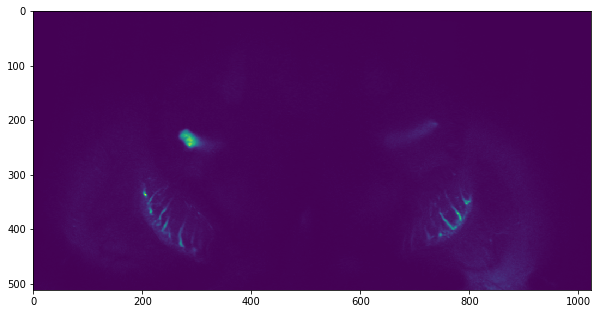

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(brains['clandinin'][6][:,:,170].T)

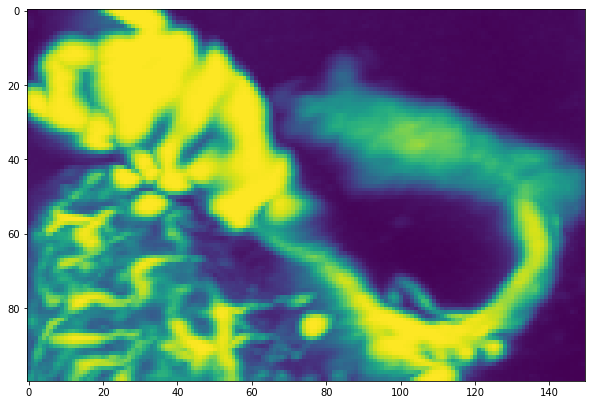

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(brains_cropped['clandinin'][6],axis=2).T)

In [104]:
########################################################
### Generate normalized mean images of green channel ###
########################################################

meanbrains = {}
for brain_type in brain_types:
    meanbrain = np.zeros(brains_cropped[brain_type][0].shape)
    for i in range(len(brains_cropped[brain_type])):
        meanbrain += brains_cropped[brain_type][i]/np.max(brains_cropped[brain_type][i])
    meanbrains[brain_type] = meanbrain

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


(-0.5, 99.5, 139.5, -0.5)

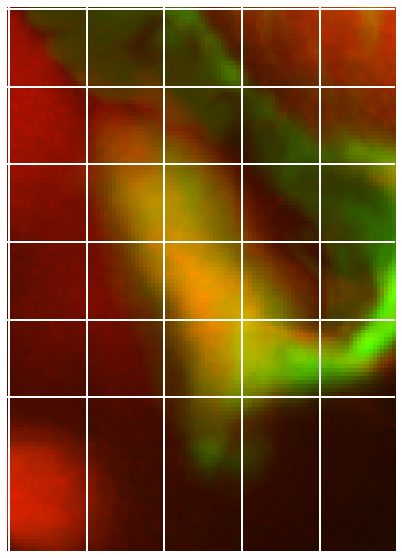

In [122]:
plt.figure(figsize=(10,10))
axis = 2
uncropped = True

type1 = 'clandinin'
type2 = 'murthy'

if uncropped:
    g=np.max(meanbrains[type1],axis=axis)
    r=np.max(meanbrains[type2],axis=axis)
    #b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)
else:
    g=np.max(mean_binary_image_c,axis=axis)
    r=np.max(mean_binary_image_m,axis=axis)
    #b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)

b = np.zeros(g.shape)
    
g/=np.max(g)
r/=np.max(r)
b/=np.max(b)
rgb = np.concatenate((r[...,np.newaxis],g[...,np.newaxis],b[...,np.newaxis]),axis=2)
plt.imshow(rgb)

# for i in range(len(centroids[type1])):
#     plot_centroid(centroids[type1][i][0],
#                   centroids[type1][i][1],
#                   centroids[type1][i][2],axis,color='w')
    
# for i in range(len(centroids[type2])):
#     plot_centroid(centroids[type2][i][0],
#                   centroids[type2][i][1],
#                   centroids[type2][i][2],axis,color='blue')
    
# for i in range(len(centroids['connectome'])):
#     plot_centroid(centroids['connectome'][i][0],
#                   centroids['connectome'][i][1],
#                   centroids['connectome'][i][2],axis,color='r')

draw_grid(vlines=5, hlines=6, lw=2)
plt.axis('off')

In [45]:
##################
### load masks ###
##################

pvlp_mask = "/oak/stanford/groups/trc/data/Alex/ROI_masks/pvlp_and_plp.nii"
pvlp_mask = ants.image_read(pvlp_mask).numpy()
mask_eroded = binary_erosion(pvlp_mask, structure=np.ones((2,2,2)))
mask_dilated = binary_dilation(mask_eroded, iterations=2)
pvlp_mask_cropped = mask_dilated[bbox['x_start']:bbox['x_end'],
                               bbox['y_start']:bbox['y_end'],
                               bbox['z_start']:bbox['z_end']]

# nolo_mask = "/oak/stanford/groups/trc/data/Alex/ROI_masks/no_lo.nii"
# nolo_mask = ants.image_read(nolo_mask).numpy()
# mask_eroded = binary_erosion(nolo_mask, structure=np.ones((2,2,2)))
# mask_dilated = binary_dilation(mask_eroded, iterations=2)
# nolo_mask_cropped = mask_dilated[bbox['x_start']:bbox['x_end'],
#                                bbox['y_start']:bbox['y_end'],
#                                bbox['z_start']:bbox['z_end']]

In [53]:
###########################
### calculate centroids ###
###########################

thresh_scales = {'clandinin': [1,1,1,1,1,1,1,1,1],
                 'murthy': [2,2,2,1.5,1,1.5,1.5,1.5],
                 'clandinin_flip': [1,1,1,1,1,1,2,1,1],
                 'murthy_flip': [1,2,2,1,1,2,1,2]}

centroids = {}
for brain_type in brain_types:
    centroids[brain_type] = []
    for i in range(len(brains_cropped[brain_type])):
        #binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize=True)
        binary_image = binarize_image(brains_cropped[brain_type][i],1,binarize=True)

        #binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        cx,cy,cz = calc_centroid(binary_image)
        centroids[brain_type].append((cx,cy,cz))

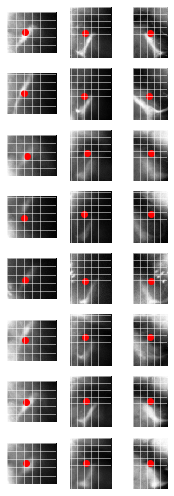

In [57]:
plt.figure(figsize=(3,10))
binarize=False
brain_type = 'murthy_flip'
for i in range(len(brains_cropped[brain_type])):
    for axis in [0,1,2]:
        plt.subplot(9,3,(3*i+axis)+1)
        binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
        #binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        plt.imshow(np.mean(binary_image,axis=axis),cmap='Greys_r')
        draw_grid()
        plt.axis('off')
        cx,cy,cz = calc_centroid(binary_image)
        plot_centroid(cx,cy,cz,axis)

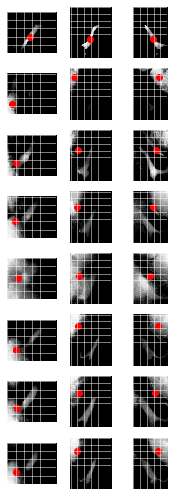

In [62]:
plt.figure(figsize=(3,10))
binarize=True
brain_type = 'murthy'
for i in range(len(brains_cropped[brain_type])):
    for axis in [0,1,2]:
        plt.subplot(9,3,(3*i+axis)+1)
        binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
        #binary_image*=pvlp_mask_cropped
        #binary_image = clean_anat(binary_image)
        plt.imshow(np.mean(binary_image,axis=axis),cmap='Greys_r')
        draw_grid()
        plt.axis('off')
        cx,cy,cz = calc_centroid(binary_image)
        plot_centroid(cx,cy,cz,axis)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


(-0.5, 119.5, 149.5, -0.5)

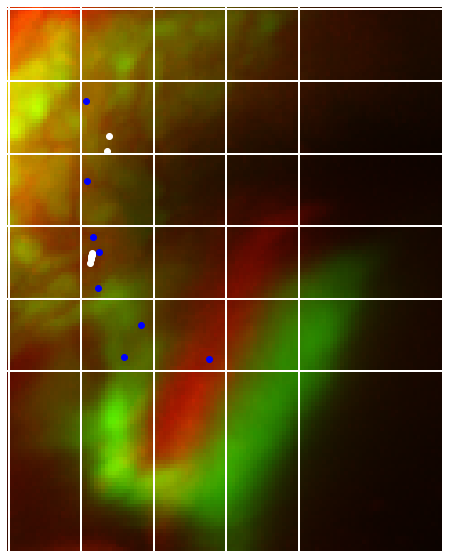

In [76]:
plt.figure(figsize=(10,10))
axis = 1
uncropped = True


type1 = 'clandinin'
type2 = 'murthy'

if uncropped:
    g=np.max(meanbrains[type1],axis=axis)
    r=np.max(meanbrains[type2],axis=axis)
    #b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)
else:
    g=np.max(mean_binary_image_c,axis=axis)
    r=np.max(mean_binary_image_m,axis=axis)
    #b=np.max(LC11_fda_cropped*pvlp_mask_cropped, axis=axis)

b = np.zeros(g.shape)
    
g/=np.max(g)
r/=np.max(r)
b/=np.max(b)
rgb = np.concatenate((r[...,np.newaxis],g[...,np.newaxis],b[...,np.newaxis]),axis=2)
plt.imshow(rgb)

for i in range(len(centroids[type1])):
    plot_centroid(centroids[type1][i][0],
                  centroids[type1][i][1],
                  centroids[type1][i][2],axis,color='w')
    
for i in range(len(centroids[type2])):
    plot_centroid(centroids[type2][i][0],
                  centroids[type2][i][1],
                  centroids[type2][i][2],axis,color='blue')
    
# for i in range(len(centroids['connectome'])):
#     plot_centroid(centroids['connectome'][i][0],
#                   centroids['connectome'][i][1],
#                   centroids['connectome'][i][2],axis,color='r')

draw_grid(vlines=5, hlines=6, lw=2)
plt.axis('off')